In [1]:
# IMPORTS
##########
##########

import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

from astropy.visualization import hist
from astropy.stats import histogram
from astropy.io import fits
import astropy.units as u

import ccdproc
from ccdproc import subtract_overscan
from ccdproc import trim_image
from ccdproc import CCDData

In [2]:
#CLD this cell is for all of the constants added throughout the notebook

#CLD local path to data, must change in order to run on personal computer
path = '../../../../imaging/reduced_data/'

Based on visual inspection, the overscan region on the left hand side goes from 1 to 54 and on the left hand side seems to go from 2101 to 2200. I will be adding this to the header of every image we are working with (or, if working in python to fits indices, 0 to 52 and 2100 to 2199). From the log book: 

-bais: a093-a111.fits

-darks: d01-d15.fits

-flats: a001-a062 (1-21 Halpha, 22-28 are U, 29-42 B, 43-49 V, 50-55 R, 56-62 I)

665.8330812766335


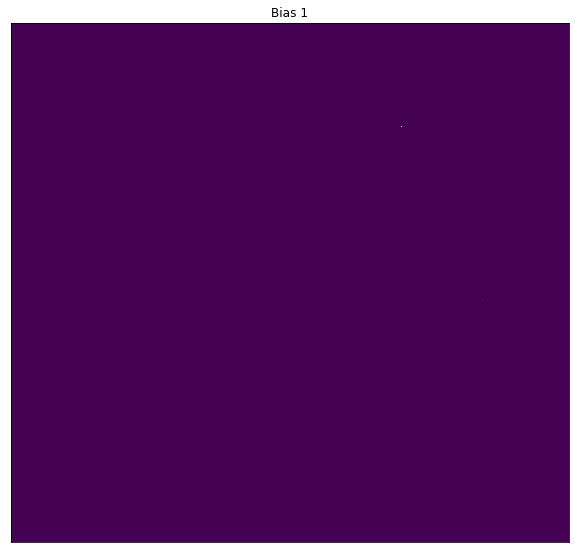

In [3]:
#CLD using python to plot the lines and columns of one of the biases
#CLD I will be using a093.fits for this excersice
#CLD opeing bias frame and plot to show it
b1_data = fits.getdata(path+"a093.fits")
print(np.mean(b1_data))
fig = plt.subplots(1,1,figsize=(10,10))
plt.imshow(b1_data, vmin=666, vmax=7536)
plt.xticks([])
plt.yticks([])
plt.title('Bias 1')
plt.grid(False)
plt.show()

In [4]:
#CLD the chip is 2048 X 2200 so center should be like 1024 and 1100
#CLD because of this will be looking at a region around like 1020-1028 and 1096 and 1104
b1_center = b1_data[1020:1028, 1096:1104]

#CLD RMS will be the standard deviation
rms = np.std(b1_center)

#CLD the mean is the mean
mean = np.mean(b1_center)

print('The RMS is: '+str(rms))
print('The mean is: '+str(mean))

The RMS is: 9.316261299973021
The mean is: 671.359375


## Problem 5

This is an attempt to quantify whether or not the biases are a good example of the overscan region throughout the night. To do this, first looking at all of the biases taken and the mean level of all of the pixels in the bias. Then look at the mean level of the overscan region, which is noted in one of the first cells, in a different set of images that were taken through out the night, ie with different time signatures. 

For this I will be looking at every other science image up until the baises. I will also be looking at the lefthand side of the overscan, or the bigger portion. 

In [5]:
#CLD begin by opening all of the baises data into a master data frame
baises_data = []
for i in range(111-93):
    if i<7:
        data = fits.getdata(path+"a0"+str(int(i+93))+".fits")
        baises_data.append(data)
    if i>=7:
        data = fits.getdata(path+"a"+str(int(i+93))+".fits")
        baises_data.append(data)
        
baises_data = np.array(baises_data)

#CLD making an array of the mean level of each bias
bais_mean = []
for i in range(len(baises_data)):
    mean = np.mean(baises_data[i,:])
    bais_mean.append(mean)
    
bais_mean = np.array(bais_mean)
print(bais_mean)
print(np.std(bais_mean))

[665.83308128 665.50395131 665.5575142  665.67133811 665.65969438
 665.63690829 665.59073242 665.55084783 665.57650435 665.5441748
 665.5616748  665.55110019 665.54791104 665.58815718 665.53799472
 665.60195113 665.59595925 665.62843905]
0.0717694806159146


Overall, it seems like the bais level is pretty consistent throughout the night. This is seen in the low standard deviation from each mean.

Next, I will do a similar process to look at the overscan region in the science images.

In [6]:
#CLD begin by opening all of the flats overscan data into a master data frame
sci_data = []
for i in range(92-70):
    data = fits.getdata(path+"a0"+str(int(i+70))+".fits")
    sci_data.append(data[:,2102:2200])
        
sci_data = np.array(sci_data)

#CLD making an array of the mean level of each flat overscan region
sci_mean = []
for i in range(len(sci_data)):
    mean = np.mean(sci_data[i,:])
    sci_mean.append(mean)
    
sci_mean = np.array(sci_mean)
print(sci_mean)
print(np.std(sci_mean))

[660.90770488 660.04110531 661.03261519 660.12828842 661.01810627
 661.05385045 662.05293367 663.05667052 663.56174267 664.54508131
 665.76598872 661.64457609 663.12129803 663.78644173 662.89166633
 662.45422114 663.01397581 661.75139509 662.93529775 661.95527742
 663.17296118 664.70322465]
1.4565186370825964


There is definitley much more internal deviation between the overscan region of these flats.

To compare the standard variation in the baises to the variation in the overscan regions of the flats, I am going to subtract the mean of the mean for the biases from all of the means of the flats. If they are close to 0, then the bias level is similar to the overscan level in the flats. 

In [7]:
#CLD using the mean of the means as repersentative variation
#CLD feel comfortable doing this as there is very little deviation between the means
bais_mean_level = np.mean(bais_mean)

#CLD subtracting this repersentative mean to the means of the flats
differences = sci_mean - bais_mean_level

print(differences)

[-4.68884703 -5.5554466  -4.56393671 -5.46826348 -4.57844564 -4.54270146
 -3.54361823 -2.53988139 -2.03480924 -1.05147059  0.16943681 -3.95197582
 -2.47525388 -1.81011018 -2.70488557 -3.14233077 -2.5825761  -3.84515682
 -2.66125416 -3.64127448 -2.42359073 -0.89332726]


To me, this indicates that the mean level of the baises, and therefore the master bais, would not be a good description of the kind of variation we see in the overscan region through out the night. This is especially true early on. It seems it would be best to model the overscan region in each frame and then subtract this out from the images.

## Problem 6

For this problem, I am first going to investigate the best overscan modeling on a science image in this order: ’chebychev’, ’legandre’, and ’hermite’, and ’polynomial' order 1 through 8. I will look at science image 85 in the V filter. I will be using an overscan region of [ :,2102-2200]. Some of the first pixels of overscan are left out as there is not an instanteous drop off at the edge of the overscan, but more gradual. By omitting some of the frist values, you get a better fit.

(2048, 90)
(2048,)


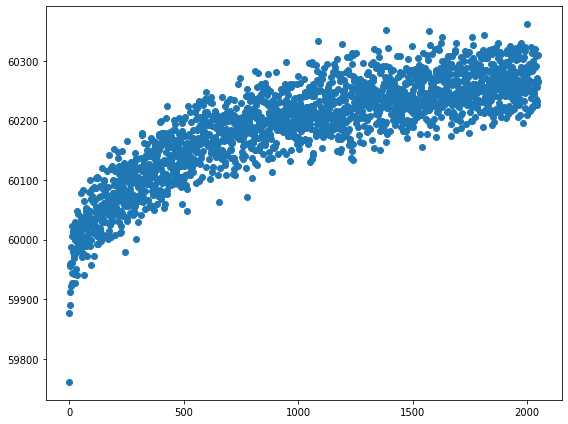

In [11]:
#CLD let's begin by just plotting the overscan region of the flat I am going to be looking at
#CLD loading in the flat data
flat_data = fits.getdata(path+"a047.fits")

flat_overscan = flat_data[:,2110:2200]
print(flat_overscan.shape)
flat_overscan_combine = np.sum(flat_overscan, axis=1) #CLD combining over the columns and not the rows
print(flat_overscan_combine.shape)

pixels = np.linspace(0,2048,2048)
fig,ax = plt.subplots(figsize=(8,6))
ax.scatter(pixels, flat_overscan_combine);
fig.tight_layout()
plt.show(fig);

In [12]:
#CLD importing the astropy.models package for ccdproc purposes
from astropy.modeling import models, fitting

#CLD loading in the flat data
flat_data = fits.getdata(path+"a047.fits")

#CLD changing fits array data to CCDdata
ccd_flat = CCDData(flat_data, unit=u.adu)

#CLD instantiating polynomial models
p1 = models.Polynomial1D(degree=1)
p2 = models.Polynomial1D(degree=2)
p3 = models.Polynomial1D(degree=3)
p4 = models.Polynomial1D(degree=4)
p5 = models.Polynomial1D(degree=5)
p6 = models.Polynomial1D(degree=6)
p7 = models.Polynomial1D(degree=7)
p8 = models.Polynomial1D(degree=8)

#CLD instantiating the other model types for orders 1 through 8
c1 = models.Chebyshev1D(degree=1)
c2 = models.Chebyshev1D(degree=2)
c3 = models.Chebyshev1D(degree=3)
c4 = models.Chebyshev1D(degree=4)
c5 = models.Chebyshev1D(degree=5)
c6 = models.Chebyshev1D(degree=6)
c7 = models.Chebyshev1D(degree=7)
c8 = models.Chebyshev1D(degree=8)

le1 = models.Legendre1D(degree=1)
le2 = models.Legendre1D(degree=2)
le3 = models.Legendre1D(degree=3)
le4 = models.Legendre1D(degree=4)
le5 = models.Legendre1D(degree=5)
le6 = models.Legendre1D(degree=6)
le7 = models.Legendre1D(degree=7)
le8 = models.Legendre1D(degree=8)

h1 = models.Hermite1D(degree=1)
h2 = models.Hermite1D(degree=2)
h3 = models.Hermite1D(degree=3)
h4 = models.Hermite1D(degree=4)
h5 = models.Hermite1D(degree=5)
h6 = models.Hermite1D(degree=6)
h7 = models.Hermite1D(degree=7)
h8 = models.Hermite1D(degree=8)

#CLD chebyshev model subtractions
sub_c1 = ccdproc.subtract_overscan(ccd_flat, fits_section='[2110:2200,:]', model=c1)
sub_c2 = ccdproc.subtract_overscan(ccd_flat, fits_section='[2110:2200,:]', model=c2)
sub_c3 = ccdproc.subtract_overscan(ccd_flat, fits_section='[2110:2200,:]', model=c3)
sub_c4 = ccdproc.subtract_overscan(ccd_flat, fits_section='[2110:2200,:]', model=c4)
sub_c5 = ccdproc.subtract_overscan(ccd_flat, fits_section='[2110:2200,:]', model=c5)
sub_c6 = ccdproc.subtract_overscan(ccd_flat, fits_section='[2110:2200,:]', model=c6)
sub_c7 = ccdproc.subtract_overscan(ccd_flat, fits_section='[2110:2200,:]', model=c7)
sub_c8 = ccdproc.subtract_overscan(ccd_flat, fits_section='[2110:2200,:]', model=c8)

#CLD legendre model subtractions
sub_le1 = ccdproc.subtract_overscan(ccd_flat, fits_section='[2110:2200,:]', model=le1)
sub_le2 = ccdproc.subtract_overscan(ccd_flat, fits_section='[2110:2200,:]', model=le2)
sub_le3 = ccdproc.subtract_overscan(ccd_flat, fits_section='[2110:2200,:]', model=le3)
sub_le4 = ccdproc.subtract_overscan(ccd_flat, fits_section='[2110:2200,:]', model=le4)
sub_le5 = ccdproc.subtract_overscan(ccd_flat, fits_section='[2110:2200,:]', model=le5)
sub_le6 = ccdproc.subtract_overscan(ccd_flat, fits_section='[2110:2200,:]', model=le6)
sub_le7 = ccdproc.subtract_overscan(ccd_flat, fits_section='[2110:2200,:]', model=le7)
sub_le8 = ccdproc.subtract_overscan(ccd_flat, fits_section='[2110:2200,:]', model=le8)

#CLD Hermite model subtractions
sub_h1 = ccdproc.subtract_overscan(ccd_flat, fits_section='[2110:2200,:]', model=h1)
sub_h2 = ccdproc.subtract_overscan(ccd_flat, fits_section='[2110:2200,:]', model=h2)
sub_h3 = ccdproc.subtract_overscan(ccd_flat, fits_section='[2110:2200,:]', model=h3)
sub_h4 = ccdproc.subtract_overscan(ccd_flat, fits_section='[2110:2200,:]', model=h4)
sub_h5 = ccdproc.subtract_overscan(ccd_flat, fits_section='[2110:2200,:]', model=h5)
sub_h6 = ccdproc.subtract_overscan(ccd_flat, fits_section='[2110:2200,:]', model=h6)
sub_h7 = ccdproc.subtract_overscan(ccd_flat, fits_section='[2110:2200,:]', model=h7)
sub_h8 = ccdproc.subtract_overscan(ccd_flat, fits_section='[2110:2200,:]', model=h8)

#CLD polynomial model subtractions
sub_p1 = ccdproc.subtract_overscan(ccd_flat, fits_section='[2110:2200,:]', model=p1)
sub_p2 = ccdproc.subtract_overscan(ccd_flat, fits_section='[2110:2200,:]', model=p2)
sub_p3 = ccdproc.subtract_overscan(ccd_flat, fits_section='[2110:2200,:]', model=p3)
sub_p4 = ccdproc.subtract_overscan(ccd_flat, fits_section='[2110:2200,:]', model=p4)
sub_p5 = ccdproc.subtract_overscan(ccd_flat, fits_section='[2110:2200,:]', model=p5)
sub_p6 = ccdproc.subtract_overscan(ccd_flat, fits_section='[2110:2200,:]', model=p6)
sub_p7 = ccdproc.subtract_overscan(ccd_flat, fits_section='[2110:2200,:]', model=p7)
sub_p8 = ccdproc.subtract_overscan(ccd_flat, fits_section='[2110:2200,:]', model=p8)

 [astropy.modeling.fitting]
 [astropy.modeling.fitting]
 [astropy.modeling.fitting]
 [astropy.modeling.fitting]
 [astropy.modeling.fitting]


I will now be displaying this single science image with the different orders and models of subtraction. The first panel will be the Chebyshev models, the next will be Legendre, then Hermite, and lastly the Polynomial fits, all in sequential order (ie, the first graph is degree=1, the next to the right is degree=2, etc etc)

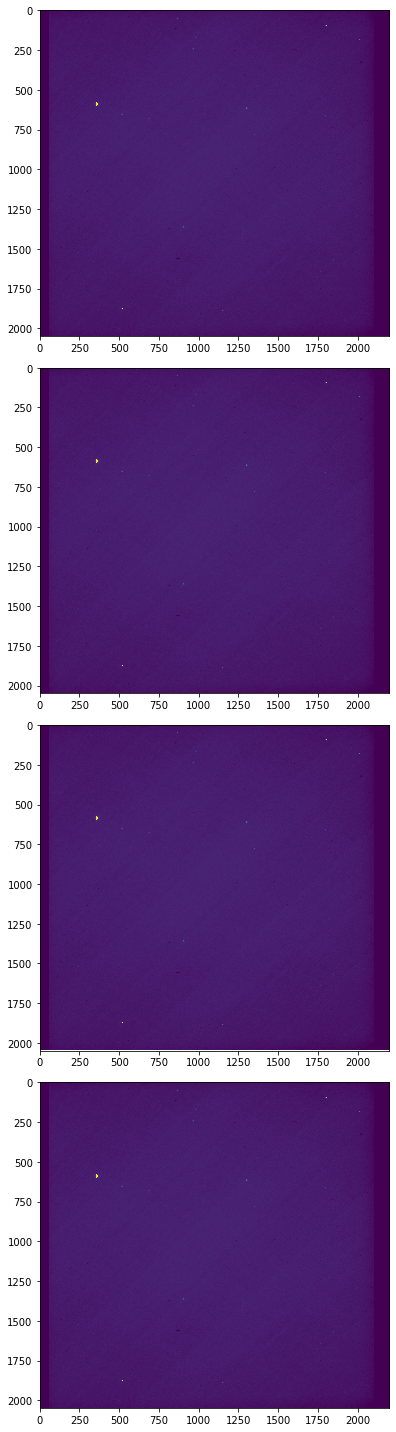

In [13]:
#CLD the plots of the highest orders side by side
c = [np.array(sub_c1), np.array(sub_c2),np.array(sub_c3),np.array(sub_c4),np.array(sub_c5),np.array(sub_c6),
    np.array(sub_c7),np.array(sub_c8)]
le = [np.array(sub_le1), np.array(sub_le2),np.array(sub_le3),np.array(sub_le4),np.array(sub_le5),np.array(sub_le6),
    np.array(sub_le7),np.array(sub_le8)]
h = [np.array(sub_h1), np.array(sub_h2),np.array(sub_h3),np.array(sub_h4),np.array(sub_h5),np.array(sub_h6),
    np.array(sub_h7),np.array(sub_h8)]
p = [np.array(sub_p1), np.array(sub_p2),np.array(sub_p3),np.array(sub_p4),np.array(sub_p5),np.array(sub_p6),
    np.array(sub_p7),np.array(sub_p8)]

fig, ax = plt.subplots(4,1,figsize=(30,20))
ax[0].imshow(c[7], vmin=np.mean(c[7]), vmax=np.max(c[7]))
ax[1].imshow(le[7], vmin=np.mean(le[7]), vmax=np.max(le[7]))
ax[2].imshow(h[7], vmin=np.mean(h[7]), vmax=np.max(h[7]))
ax[3].imshow(p[7], vmin=np.mean(p[7]), vmax=np.max(p[7]))
fig.tight_layout()
plt.show(fig);

To make an arugment about the order, you want the lowest order that gives you the best RMS, or at least without diminishing returns. To argue for the model type, going to apply the models to the overscan regions. 

 [astropy.modeling.fitting]


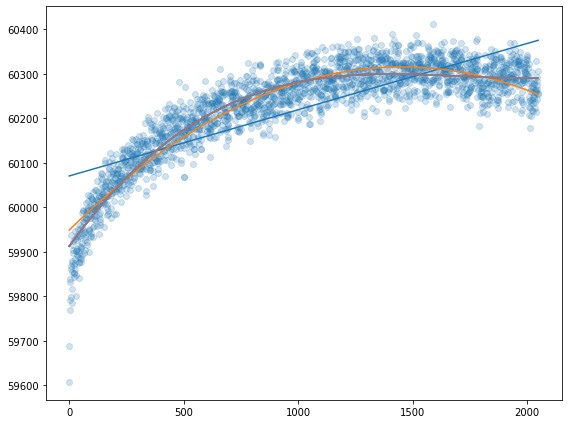

68.02825073313856
40.87641215631072
38.4888566877479
38.48885745185958
38.48885745186049
38.488857451860476
38.48885745186049
38.48885745186048


In [98]:
#CLD let's begin by just plotting the overscan region of the flat I am going to be looking at
#CLD loading in the flat data
flat_data = fits.getdata(path+"a010.fits")

flat_overscan = flat_data[:,2110:2200]
flat_overscan_combine = np.sum(flat_overscan, axis=1) #CLD combining over the columns and not the rows
pixels = np.linspace(0,2048,2048)

fitter = fitting.LinearLSQFitter()

bfp1 = fitter(p1, pixels, flat_overscan_combine)
bfp2 = fitter(p2, pixels, flat_overscan_combine)
bfp3 = fitter(p3, pixels, flat_overscan_combine)
bfp4 = fitter(p4, pixels, flat_overscan_combine)
bfp5 = fitter(p5, pixels, flat_overscan_combine)
bfp6 = fitter(p6, pixels, flat_overscan_combine)
bfp7 = fitter(p7, pixels, flat_overscan_combine)
bfp8 = fitter(p8, pixels, flat_overscan_combine)

fig,ax = plt.subplots(figsize=(8,6))
ax.scatter(pixels, flat_overscan_combine, alpha=0.2)
ax.plot(pixels, bfp1(pixels))
ax.plot(pixels, bfp2(pixels))
ax.plot(pixels, bfp3(pixels))
ax.plot(pixels, bfp4(pixels))
ax.plot(pixels, bfp5(pixels))
ax.plot(pixels, bfp6(pixels))
ax.plot(pixels, bfp7(pixels))
ax.plot(pixels, bfp8(pixels))
fig.tight_layout()
plt.show(fig);

print(np.std(bfp1(pixels) - flat_overscan_combine))
print(np.std(bfp2(pixels) - flat_overscan_combine))
print(np.std(bfp3(pixels) - flat_overscan_combine))
print(np.std(bfp4(pixels) - flat_overscan_combine))
print(np.std(bfp5(pixels) - flat_overscan_combine))
print(np.std(bfp6(pixels) - flat_overscan_combine))
print(np.std(bfp7(pixels) - flat_overscan_combine))
print(np.std(bfp8(pixels) - flat_overscan_combine))

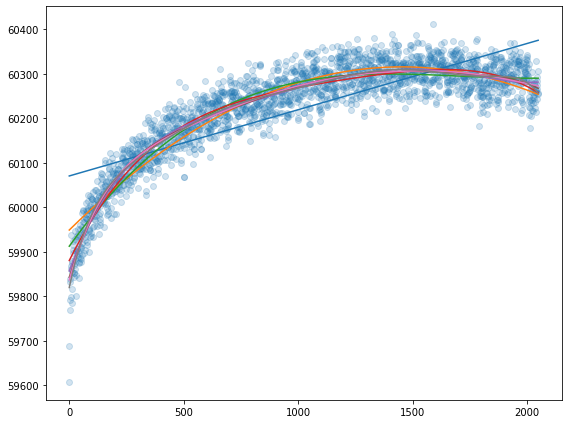

68.02825073313858
40.87641215631074
38.48885668774802
36.95363067354296
36.256612838937606
36.04024154412678
36.00829614439733
35.75562709305338


In [99]:
#CLD chebyshev
bfc1 = fitter(c1, pixels, flat_overscan_combine)
bfc2 = fitter(c2, pixels, flat_overscan_combine)
bfc3 = fitter(c3, pixels, flat_overscan_combine)
bfc4 = fitter(c4, pixels, flat_overscan_combine)
bfc5 = fitter(c5, pixels, flat_overscan_combine)
bfc6 = fitter(c6, pixels, flat_overscan_combine)
bfc7 = fitter(c7, pixels, flat_overscan_combine)
bfc8 = fitter(c8, pixels, flat_overscan_combine)

fig,ax = plt.subplots(figsize=(8,6))
ax.scatter(pixels, flat_overscan_combine, alpha=0.2)
ax.plot(pixels, bfc1(pixels))
ax.plot(pixels, bfc2(pixels))
ax.plot(pixels, bfc3(pixels))
ax.plot(pixels, bfc4(pixels))
ax.plot(pixels, bfc5(pixels))
ax.plot(pixels, bfc6(pixels))
ax.plot(pixels, bfc7(pixels))
ax.plot(pixels, bfc8(pixels))
fig.tight_layout()
plt.show(fig);

print(np.std(bfc1(pixels) - flat_overscan_combine))
print(np.std(bfc2(pixels) - flat_overscan_combine))
print(np.std(bfc3(pixels) - flat_overscan_combine))
print(np.std(bfc4(pixels) - flat_overscan_combine))
print(np.std(bfc5(pixels) - flat_overscan_combine))
print(np.std(bfc6(pixels) - flat_overscan_combine))
print(np.std(bfc7(pixels) - flat_overscan_combine))
print(np.std(bfc8(pixels) - flat_overscan_combine))

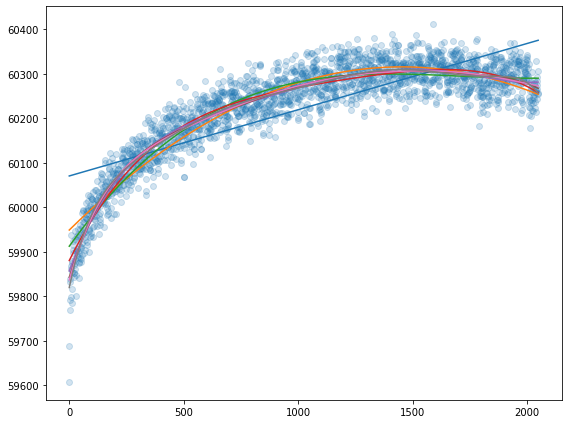

68.02825073313858
40.876412156310735
38.488856687748
36.9536306735429
36.256612838937336
36.04024154412678
36.00829614439728
35.75562709305332


In [100]:
#CLD legendre
bfl1 = fitter(le1, pixels, flat_overscan_combine)
bfl2 = fitter(le2, pixels, flat_overscan_combine)
bfl3 = fitter(le3, pixels, flat_overscan_combine)
bfl4 = fitter(le4, pixels, flat_overscan_combine)
bfl5 = fitter(le5, pixels, flat_overscan_combine)
bfl6 = fitter(le6, pixels, flat_overscan_combine)
bfl7 = fitter(le7, pixels, flat_overscan_combine)
bfl8 = fitter(le8, pixels, flat_overscan_combine)

fig,ax = plt.subplots(figsize=(8,6))
ax.scatter(pixels, flat_overscan_combine, alpha=0.2)
ax.plot(pixels, bfl1(pixels))
ax.plot(pixels, bfl2(pixels))
ax.plot(pixels, bfl3(pixels))
ax.plot(pixels, bfl4(pixels))
ax.plot(pixels, bfl5(pixels))
ax.plot(pixels, bfl6(pixels))
ax.plot(pixels, bfl7(pixels))
ax.plot(pixels, bfl8(pixels))
fig.tight_layout()
plt.show(fig);

print(np.std(bfl1(pixels) - flat_overscan_combine))
print(np.std(bfl2(pixels) - flat_overscan_combine))
print(np.std(bfl3(pixels) - flat_overscan_combine))
print(np.std(bfl4(pixels) - flat_overscan_combine))
print(np.std(bfl5(pixels) - flat_overscan_combine))
print(np.std(bfl6(pixels) - flat_overscan_combine))
print(np.std(bfl7(pixels) - flat_overscan_combine))
print(np.std(bfl8(pixels) - flat_overscan_combine))

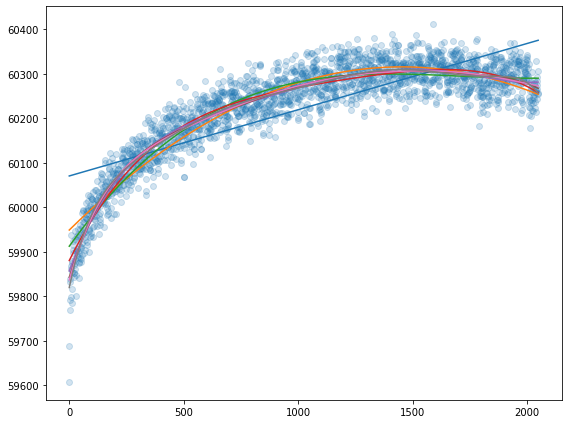

68.02825073313856
40.87641215631073
38.48885668774807
36.95363067354296
36.25661283893746
36.040241544126914
36.00829614439737
35.755627093053384


In [101]:
#CLD hermite
bfh1 = fitter(h1, pixels, flat_overscan_combine)
bfh2 = fitter(h2, pixels, flat_overscan_combine)
bfh3 = fitter(h3, pixels, flat_overscan_combine)
bfh4 = fitter(h4, pixels, flat_overscan_combine)
bfh5 = fitter(h5, pixels, flat_overscan_combine)
bfh6 = fitter(h6, pixels, flat_overscan_combine)
bfh7 = fitter(h7, pixels, flat_overscan_combine)
bfh8 = fitter(h8, pixels, flat_overscan_combine)

fig,ax = plt.subplots(figsize=(8,6))
ax.scatter(pixels, flat_overscan_combine, alpha=0.2)
ax.plot(pixels, bfh1(pixels))
ax.plot(pixels, bfh2(pixels))
ax.plot(pixels, bfh3(pixels))
ax.plot(pixels, bfh4(pixels))
ax.plot(pixels, bfh5(pixels))
ax.plot(pixels, bfh6(pixels))
ax.plot(pixels, bfh7(pixels))
ax.plot(pixels, bfh8(pixels))
fig.tight_layout()
plt.show(fig);

print(np.std(bfh1(pixels) - flat_overscan_combine))
print(np.std(bfh2(pixels) - flat_overscan_combine))
print(np.std(bfh3(pixels) - flat_overscan_combine))
print(np.std(bfh4(pixels) - flat_overscan_combine))
print(np.std(bfh5(pixels) - flat_overscan_combine))
print(np.std(bfh6(pixels) - flat_overscan_combine))
print(np.std(bfh7(pixels) - flat_overscan_combine))
print(np.std(bfh8(pixels) - flat_overscan_combine))

Based on the standard deviations, the Chebyshev model, the Legendre model, and the Hermite model all preform the same (and better than the polynomial model) for the varying degrees. You want the lowest degrees possible to have the least amount of wiggles, and you get diminishing returns passed an order of about 4. Because of this I am going to use the Chebyshev model of order 4 for my model.

Now, I am going to iteratively subtract and remove the overscan for each image in this folder and save it as a"number"ot.fits I will also be doing this subtraction for the darks as they should have the overscan region in them and be affected by these things.

In [91]:
#CLD making look to subtract and trim all images, minus darks and gains, in the imaging folder and to save them with
#CLD the ot addition to indicate this process having had happened
#CLD doing the flats first
for i in range(0,(62-5)+1):
    if i<5:
        data = fits.getdata(path+"a00"+str(i+5)+".fits")
    if i>=5 and i<(62-5):
        data = fits.getdata(path+"a0"+str(i+5)+".fits")
    if i==(62-5):
        data = fits.getdata(path+'a0'+str(i+5)+'.fits')
    
    ccddata = CCDData(data, unit=u.adu)
    sub = ccdproc.subtract_overscan(ccddata, fits_section='[2110:2200,:]', model=c4)
    trim_sub = ccdproc.trim_image(ccddata, fits_section='[54:2101,:]')
    im = np.asarray(trim_sub)
    
    if i<5:
        fits.writeto(path+"a00"+str(i+5)+"ot.fits", im, overwrite=True)
    if i>=5 and i<(62-5):
        fits.writeto(path+"a0"+str(i+5)+"ot.fits", im, overwrite=True)
    if i==(62-5):
        fits.writeto(path+'a0'+str(i+5)+'ot.fits', im, overwrite=True)

In [92]:
#CLD doing the first batch of sciences 74-92 because based on the log they seem to be the good sciences
for i in range(0,(92-74)+1):
    data = fits.getdata(path+"a0"+str(i+74)+".fits")
    
    ccddata = CCDData(data, unit=u.adu)
    sub = ccdproc.subtract_overscan(ccddata, fits_section='[2110:2200,:]', model=c4)
    trim_sub = ccdproc.trim_image(ccddata, fits_section='[54:2101,:]')
    im = np.asarray(trim_sub)
    
    fits.writeto(path+"a0"+str(i+74)+"ot.fits", im, overwrite=True)

In [93]:
#CLD doing the second batch of good science after the baises 112-139 and 142-151 (i might be missing some...)
for i in range(0,(139-112)+1):
    data = fits.getdata(path+'a'+str(i+112)+'.fits')
    
    ccddata = CCDData(data, unit=u.adu)
    sub = ccdproc.subtract_overscan(ccddata, fits_section='[2110:2200,:]', model=c4)
    trim_sub = ccdproc.trim_image(ccddata, fits_section='[54:2101,:]')
    im = np.asarray(trim_sub)

    fits.writeto(path+'a'+str(i+112)+'ot.fits', im, overwrite=True)
    
for i in range(0,(151-142)+1):
    data = fits.getdata(path+'a'+str(i+142)+'.fits')
    
    ccddata = CCDData(data, unit=u.adu)
    sub = ccdproc.subtract_overscan(ccddata, fits_section='[2110:2200,:]', model=c4)
    trim_sub = ccdproc.trim_image(ccddata, fits_section='[54:2101,:]')
    im = np.asarray(trim_sub)

    fits.writeto(path+'a'+str(i+142)+'ot.fits', im, overwrite=True)

In [37]:
#CLD subtracting the overscan and trimming the darks
for i in range(15):
    if i<9:
        data = fits.getdata(path+"d00"+str(i+1)+".fits")
    if i>=9:
        data = fits.getdata(path+"d0"+str(i+1)+".fits")
        
    ccddata = CCDData(data, unit=u.adu)
    sub = ccdproc.subtract_overscan(ccddata, fits_section='[2110:2200,:]', model=c4)
    trim_sub = ccdproc.trim_image(ccddata, fits_section='[54:2101,:]')
    im = np.asarray(trim_sub)
    
    if i<9:
        fits.writeto(path+"d00"+str(i+1)+"ot.fits", im, overwrite=True)
    if i>=9:
        fits.writeto(path+"d0"+str(i+1)+"ot.fits", im, overwrite=True)

In [38]:
#CLD trimming the bais images and subtracting the overscan
for i in range(111-93):
    if i<7:
        data = fits.getdata(path+"a0"+str(int(i+93))+".fits")
        data = CCDData(data, unit=u.adu)
    if i>=7:
        data = fits.getdata(path+"a"+str(int(i+93))+".fits")
        data = CCDData(data, unit=u.adu)
     
    sub = ccdproc.subtract_overscan(ccddata, fits_section='[2110:2200,:]', model=c4)
    trim_sub = ccdproc.trim_image(data, fits_section='[54:2101,:]')
    im = np.asarray(trim_sub)
    
    if i<7:
        fits.writeto(path+"a0"+str(i+93)+"ot.fits", im, overwrite=True)
    if i>=7:
        fits.writeto(path+"a"+str(i+93)+"ot.fits", im, overwrite=True)

## Problem 7

This problem deals with creating a master bias image and the investiagtion of the validaity of this master bias.

The first step will be to investigate the data in all of these images.
Will be looking at the mean level in each image, along with the standard deviation, both in the individual images, and the images as a group.

If a frame is really off, do a visual inspection and decide wether or not to discount it. 

Using the final set of images (if there is enough) make a master bias images using mean combine.

In [39]:
#CLD doing image statistics on the bais data
#CLD data loaded in from question 5
#CLD already have array of means/levels for each image individually
#CLD along with the standard dev for these means
#CLD will now be finding the std dev of pixels in each frame and the global mean

global_mean = np.mean(bais_mean)
bais_std = []
for i in range(len(baises_data)):
    std = np.std(baises_data[i,:])
    bais_std.append(std)
    
print('The global mean for all baises: '+str(global_mean))
print("The std for each image's mean from this global mean: "+str(np.std(bais_mean)))
print("")
print("The mean of each image: "+str(bais_mean))
print("\nThe std of each image from its own mean: "+str(bais_std))

The global mean for all baises: 665.5965519082425
The std for each image's mean from this global mean: 0.0717694806159146

The mean of each image: [665.83308128 665.50395131 665.5575142  665.67133811 665.65969438
 665.63690829 665.59073242 665.55084783 665.57650435 665.5441748
 665.5616748  665.55110019 665.54791104 665.58815718 665.53799472
 665.60195113 665.59595925 665.62843905]

The std of each image from its own mean: [9.532843321120467, 8.90440832302805, 8.92654707214331, 8.91783019372463, 9.15360021262778, 8.912341960236885, 8.909404771987573, 8.941481808818256, 8.907702048491156, 9.060101241508017, 9.204789382049897, 8.901463811227572, 8.899546963454311, 9.239660989475526, 8.98109366612888, 8.959462429710513, 8.932890176613084, 8.929579951952473]


From visual inspection, there is a pattern that appears in each bais frame, namely a stripe of brighter pixels that ombre off on the edges down the center of each frame.

To me, none of the baises look too, too different from one another, not to the point that I'm worried one should be investigated and discounted. Because of this, I feel comfortable making a master bais of all the bais frames included in this data set.

In [40]:
#CLD making a master bais from all of these bais images
#CLD begin by making a list of bais data in the ccddata format
baises_ccd = []
for i in range(111-93):
    if i<7:
        data = fits.getdata(path+"a0"+str(int(i+93))+"ot.fits")
        data = CCDData(data, unit=u.adu)
        baises_ccd.append(data)
    if i>=7:
        data = fits.getdata(path+"a"+str(int(i+93))+"ot.fits")
        data = CCDData(data, unit=u.adu)
        baises_ccd.append(data)
        
#CLD using the combine funciton to make a master bais image
#CLD do sigma clipping??
master_bais = ccdproc.combine(baises_ccd , method='average', sigma_clipping=True) #CLD this decision of combination 
#CLD is based off of the CCD handbook discussion on github

#CLD changing data type to np array
master_bais = np.array(master_bais)

#CLD writing this out to a fits file in the image dir
fits.writeto(path+'master_bais.fits', master_bais, overwrite=True)

RMS: 3.180576743774521


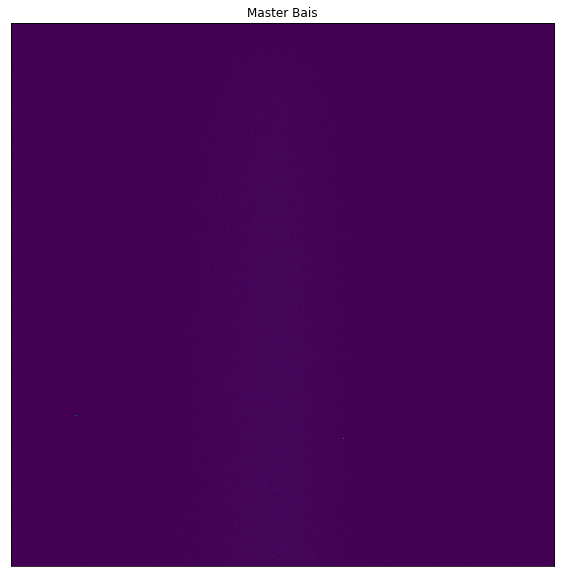

In [41]:
#CLD plotting the master bais to make sure there are no nonglobal trends that show up
master = fits.getdata(path+"master_bais.fits")

print('RMS: '+str(np.std(master)))
fig = plt.subplots(1,1,figsize=(10,10))
plt.imshow(master, vmin=np.mean(master), vmax=np.max(master))
plt.xticks([])
plt.yticks([])
plt.title('Master Bais')
plt.grid(False)
plt.show()

To look at wether or not bias subtraction would add more noise to our data, going to look at the std of a flat with overscan subtraction and the std of a flat with overscan sub AND master bias sub.

In [42]:
science = fits.getdata(path+'a047ot.fits')
print(np.std(science))
science_sub = science - master
print(np.std(science_sub))

595.2865405733322
594.4225899963229


Although not too too much, the noise in the flat is slightly better with master bias subtraction. It, at the very least, won't add noise.

I think that you do want to bais subtract all of the other frames. This is namely to get rid of the pattern that appears in the center of the bais which would not be modeled by the overscan. This pattern does still appear in the masterbais in ds9 although it is not shown when opening using imshow.

In [48]:
#CLD subtracting the masterbais from flats
for i in range(0,(62-5)+1):
    if i<5:
        data = fits.getdata(path+"a00"+str(i+5)+"ot.fits")
    if i>=5 and i<(62-5):
        data = fits.getdata(path+"a0"+str(i+5)+"ot.fits")
    if i==(62-5):
        data = fits.getdata(path+'a0'+str(i+5)+'ot.fits')
    
    im = data - master
    
    if i<5:
        fits.writeto(path+"a00"+str(i+5)+"otb.fits", im, overwrite=True)
    if i>=5 and i<(62-5):
        fits.writeto(path+"a0"+str(i+5)+"otb.fits", im, overwrite=True)
    if i==(62-5):
        fits.writeto(path+'a0'+str(i+5)+'otb.fits', im, overwrite=True)

In [50]:
#CLD first batch of sciences
for i in range(0,(92-74)+1):
    data = fits.getdata(path+"a0"+str(i+74)+"ot.fits")
    
    im = data - master
    
    fits.writeto(path+"a0"+str(i+74)+"otb.fits", im, overwrite=True)
    
#CLD doing the second batch of good science after the baises 112-139 and 142-151 (i might be missing some...)
for i in range(0,(139-112)+1):
    data = fits.getdata(path+'a'+str(i+112)+'ot.fits')
    
    im = data - master

    fits.writeto(path+'a'+str(i+112)+'otb.fits', data, overwrite=True)
    
for i in range(0,(151-142)+1):
    data = fits.getdata(path+'a'+str(i+142)+'ot.fits')

    im = data - master

    fits.writeto(path+'a'+str(i+142)+'otb.fits', im, overwrite=True)

## Problem 8

The darks are denoted by the files d001-d015. WIRO has a gain equal to 2.5 electrons/ADU. 

Gain describes the number of electrons repersented by one ADU. These fits files, as they were read out from a CCD, store an array of ADU values that we can repersent in an "image". Therefore to find the ranges of dark current, which is dimensionally equal to electrons/pixel/second, we need the number of pixels a dark substends (by defintion 2048), the amount of time it was exposed (exposure time in the header) and the maximum/minimum ADU value mulitplied by 2.5

To quantitatively examine the ranges of dark currrent in these frames, I am going to begin by opening each frame individually and get the exposure time from the header and will store it in array of exposure times.

In [54]:
#CLD opening each dark frame iteratively and storing the exp time from header into an exp time array
exp_time = []
for i in range(15):
    if i<9:
        file = fits.open(path+"d00"+str(i+1)+".fits")
        header = file[0].header
        exp_time.append(header['EXPTIME'])
    if i>=9:
        file = fits.open(path+"d0"+str(i+1)+".fits")
        header = file[0].header
        exp_time.append(header['EXPTIME'])
    
exp_time = np.array(exp_time)
print(exp_time)

[  2   2   2   2   2   5   5   5   5   5 300 300 300 300 300]


In [52]:
#CLD I will now be retriving the maximum and minimum values for each dark
#CLD the minimum value will be easy to retrive as there is no need to worry about cosmic rays
#CLD to check for cosmic rays, I will be taking the maximum value whose count is also one, as cosmic rays extend over
#CLD over multiple pixels
min_values = []
max_values = []

for i in range(15):
    if i<9:
        file = fits.getdata(path+"d00"+str(i+1)+"ot.fits")
        min_values.append(np.min(file))
        
        unique, counts = np.unique(file, return_counts=True)
        unique = unique[counts==1] #CLD masking for where counts=1
        max_values.append(np.max(unique))
        
    if i>=9:
        file = fits.getdata(path+"d0"+str(i+1)+"ot.fits")
        min_values.append(np.min(file))
        
        unique, counts = np.unique(file, return_counts=True)
        unique = unique[counts==1] #CLD masking for where counts=1       
        max_values.append(np.max(unique))

min_max = np.array([min_values, max_values])

In [75]:
#CLD now solving for dark current based off of the found/given information
gain = 2.5
min_max_e = min_max*2.5

min_range = min_max_e[0,:]/exp_time #CLD since each count is repersentative of one pixel don't need to divide by total
#CLD pixel number of ccd
max_range = min_max_e[1,:]/exp_time

for i in range(15):
    print('The range of dark current for frame '+str(i+1)+' is: ['+str(min_range[i])+', '+str(max_range[i])+']')

The range of dark current for frame 1 is: [785.0, 2082.5]
The range of dark current for frame 2 is: [785.0, 3137.5]
The range of dark current for frame 3 is: [786.25, 4326.25]
The range of dark current for frame 4 is: [785.0, 1543.75]
The range of dark current for frame 5 is: [787.5, 1905.0]
The range of dark current for frame 6 is: [313.0, 1474.5]
The range of dark current for frame 7 is: [314.5, 900.5]
The range of dark current for frame 8 is: [314.0, 2289.0]
The range of dark current for frame 9 is: [313.5, 896.0]
The range of dark current for frame 10 is: [314.0, 688.0]
The range of dark current for frame 11 is: [5.208333333333333, 44.375]
The range of dark current for frame 12 is: [5.216666666666667, 152.2]
The range of dark current for frame 13 is: [5.2, 39.075]
The range of dark current for frame 14 is: [5.175, 37.6]
The range of dark current for frame 15 is: [5.225, 50.166666666666664]


The shortest darks will not have had enough time to accurately relfect the proper dark current as what you are really seeing is the read out noise. Take the typical dark current to be those in the middle of exposure time, namely those of about 300 seconds, 11-15.

## Problem 9

The purpose of this problem is to investigate the best methods to combine the darks into a master dark.

Must investigate at least these styles of combination:

-> straight average, no clipping

-> straight median, no clipping

-> average with 3sig clipping

-> median with 3sig clipping

I will investigate these in the above order.

Also I will be leaving out dark 8 becuase its dark current range is a little funky compared to the other darks.

In [55]:
#CLD making the CCDData objs to pass combine
d1 = CCDData(fits.getdata(path+"d001ot.fits"), unit=u.adu)        
d2 = CCDData(fits.getdata(path+"d002ot.fits"), unit=u.adu)
d3 = CCDData(fits.getdata(path+"d003ot.fits"), unit=u.adu)
d4 = CCDData(fits.getdata(path+"d004ot.fits"), unit=u.adu)
d5 = CCDData(fits.getdata(path+"d005ot.fits"), unit=u.adu)
d6 = CCDData(fits.getdata(path+"d006ot.fits"), unit=u.adu)
d7 = CCDData(fits.getdata(path+"d007ot.fits"), unit=u.adu)
d9 = CCDData(fits.getdata(path+"d009ot.fits"), unit=u.adu)
d10 = CCDData(fits.getdata(path+"d010ot.fits"), unit=u.adu)
d11 = CCDData(fits.getdata(path+"d011ot.fits"), unit=u.adu)
d12 = CCDData(fits.getdata(path+"d012ot.fits"), unit=u.adu)
d13 = CCDData(fits.getdata(path+"d013ot.fits"), unit=u.adu)
d14 = CCDData(fits.getdata(path+"d014ot.fits"), unit=u.adu)
d15 = CCDData(fits.getdata(path+"d015ot.fits"), unit=u.adu)

#CLD making darks list
darks = [d1, d2, d3, d4, d5, d6, d7, d9, d10, d11, d12, d13, d14, d15]

#CLD doing the straight avg no clipping combine
straight_avg = ccdproc.combine(darks, method='average')

#CLD straight median
straight_med = ccdproc.combine(darks, method='median')

#CLD avg, 3sig
avg_3sig = ccdproc.combine(darks, method='average', sigma_clip=True) #CLD the default for sigma clip is to use mean 
#CLD func for modeling and std for sig with the low and high being 3

#CLD median 3sig
med_3sig = ccdproc.combine(darks, method='median', sigma_clip=True)

In [56]:
#CLD I am not going to display all of the above combinations
#CLD first going to turn them back into np arrays so I can do data analysis on them
straight_avg = np.array(straight_avg)
straight_med = np.array(straight_med)
avg_3sig = np.array(avg_3sig)
med_3sig = np.array(med_3sig)

RMS: 2.988847306481272


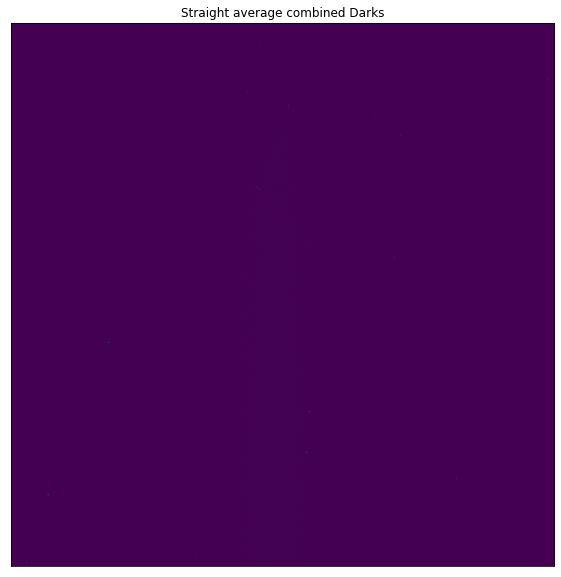

In [57]:
#CLD displaying the straight average

print('RMS: '+str(np.std(straight_avg)))
fig = plt.subplots(1,1,figsize=(10,10))
plt.imshow(straight_avg, vmin=np.mean(straight_avg))
plt.xticks([])
plt.yticks([])
plt.title('Straight average combined Darks')
plt.grid(False)
plt.show()

RMS: 2.749586290359935


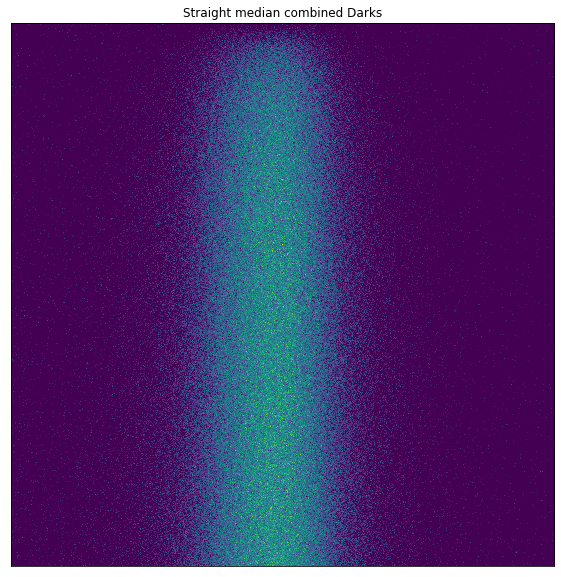

In [58]:
#CLD displaying the straight median

print('RMS: '+str(np.std(straight_med)))
fig = plt.subplots(1,1,figsize=(10,10))
plt.imshow(straight_med, vmin=np.mean(straight_med))
plt.xticks([])
plt.yticks([])
plt.title('Straight median combined Darks')
plt.grid(False)
plt.show()

RMS: 2.680949689504882


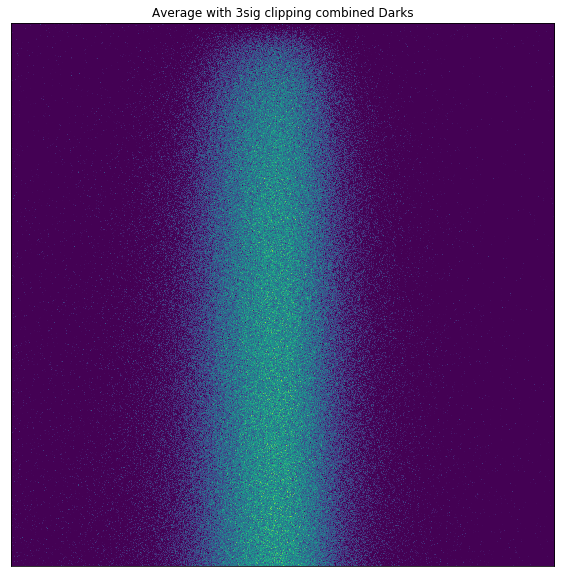

In [59]:
#CLD displaying the average with 3sig clipping

print('RMS: '+str(np.std(avg_3sig)))
fig = plt.subplots(1,1,figsize=(10,10))
plt.imshow(avg_3sig, vmin=np.mean(avg_3sig))
plt.xticks([])
plt.yticks([])
plt.title('Average with 3sig clipping combined Darks')
plt.grid(False)
plt.show()

RMS: 2.749935625555881


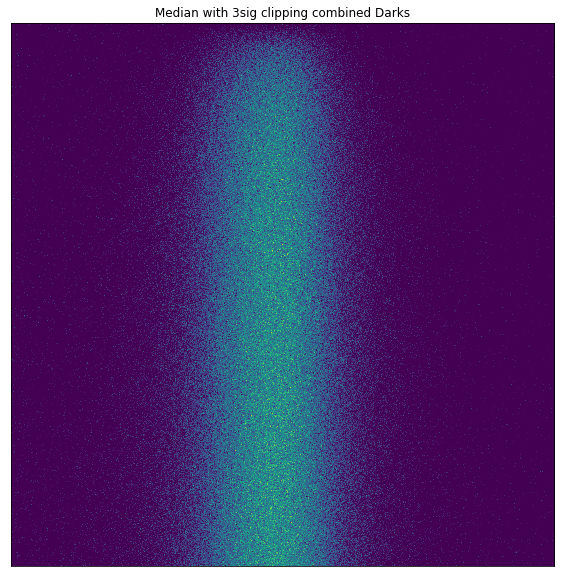

In [60]:
#CLD displaying the median with 3sig clipping

print('RMS: '+str(np.std(med_3sig)))
fig = plt.subplots(1,1,figsize=(10,10))
plt.imshow(med_3sig, vmin=np.mean(med_3sig))
plt.xticks([])
plt.yticks([])
plt.title('Median with 3sig clipping combined Darks')
plt.grid(False)
plt.show()

To me, it looks like either the average combine or the average combine with 3sig clipping is the best. 

To compare the significance of the dark counts to the general bais, compare the width of a histogram of your master darks to the mean value in a histogram of you master bais.

21.928571428571445


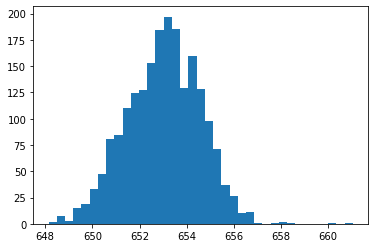

In [73]:
#CLD hist of the master dark with range of hist
hist(avg_3sig[0,:], bins='freedman');
print(np.max(avg_3sig) - np.min(avg_3sig))

665.843358145819


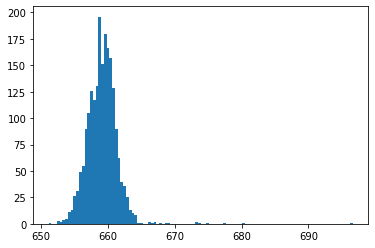

In [74]:
#CLD hist of the master bais with mean
hist(master[0,:], bins='freedman');
print(np.mean(master))

The width of the master dark compared to the mean value of the master bias is smaller and would end up adding about +/- 22/666 or +/- 3% of the value from the bias. So not a huge, huge signifigance but definitely still something.

To compare the rms of the avg_3sig master dark with the typical dark current, find the middle value of the current for the ranges of current derived from the 4 longest exposure times.

In [90]:
typical_range = np.asarray([min_range[10:], max_range[10:]]).flatten()
typical_current = np.mean(typical_range)
print('The typical current is: '+str(typical_current))

ratio = typical_current / np.std(avg_3sig)

print('This is about {:.2f} times the noise in the master dark.'.format(ratio))

The typical current is: 34.94416666666667
This is about 13.03 times the noise in the master dark.


As the noise is so much smaller than the dark current, the darks should accurately reflect the dark current, and not be dominated by the read out noise.